**Gen demo with text message example**

This is the gen version of the example from chapter 1 of the book

"Probabilistic-Programming-and-Bayesian-Methods-for-Hackers" by Cameron Davidson-Pilon

first read the data

*THIS IS JULIA - SO DOES NOT RUN ON AS AN AZURE NOTEBOOK.*

In [2]:
#import Pkg; Pkg.add("CSV")
using CSV;
#ys = CSV.read()
yst = CSV.read("txtdata.csv");

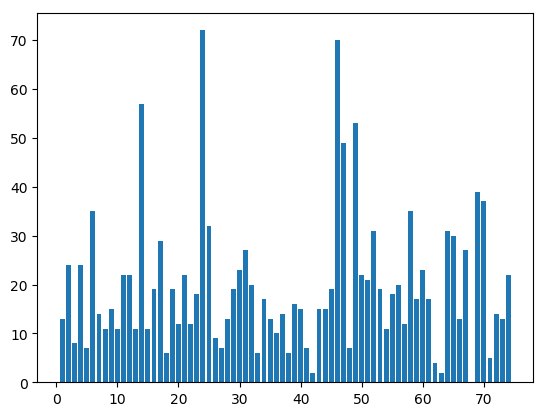

In [3]:
using PyPlot
ys = yst[:, 1];
#println(ys)
bar(1:length(ys),ys);

In [4]:
#Pkg.add("Statistics")
using Statistics
ymean = mean(ys)

19.743243243243242

In [5]:
#import Gen

we want the exponential distribution, but that is the same as the gamma distribution with alpha = 1.

In [6]:
using Gen
@gen function myModel(xs::Vector{Float64})
    alpha = 19.743243243243242
    lambda1 = @trace(gamma(1, alpha), :lambda1)
    lambda2 = @trace(gamma(1, alpha), :lambda2)
    tau = @trace(uniform_discrete(1, length(xs)), :tau)
    for (i, x) in enumerate(xs)
        if tau >= x
            lambda = lambda1
        else
            lambda = lambda2
        end
        @trace(poisson(lambda), "y-$i")
    end
end;

Create the vector of days 1 through length(ys)

In [7]:
xs = [i*1.0 for i in 1:length(ys)];

In [8]:
using Gen: get_score, simulate, get_choices
trace = simulate(myModel, (xs,))
println("tau = ", get_choices(trace)[:tau])
println("lambda1 = ", get_choices(trace)[:lambda1])
println("lambda2 = ", get_choices(trace)[:lambda2])
println("y-1 through y-3 = ", get_choices(trace)["y-1"], " ", get_choices(trace)["y-2"], " ", get_choices(trace)["y-3"])

tau = 33
lambda1 = 8.87726145988414
lambda2 = 52.58750489464655
y-1 through y-3 = 6 9 9


In [9]:
using Gen: choicemap


In [10]:
function my_inference_program(xs::Vector{Float64}, ys::Vector{Float64}, num_iters::Int)
    # Create a set of constraints fixing the 
    # y coordinates to the observed y values
    constraints = choicemap()
    for (i, y) in enumerate(ys)
        constraints["y-$i"] = y
    end
    
    # Run the model, constrained by `constraints`,
    # get an initial execution trace
    (trace, _) = generate(myModel, (xs,), constraints)
    
    # using Gen's metropolis_hastings operator.
    for iter=1:num_iters
        (trace, _) = metropolis_hastings(trace, select(:tau, :lambda1, :lambda2))
    end
    # get the choice map from the trace
    choices = get_choices(trace)
    return (choices[:tau], choices[:lambda1], choices[:lambda2])
end

my_inference_program (generic function with 1 method)

In [27]:
(tau, lambda1, lambda2) = my_inference_program(xs, ys, 30000)
println("tau: $tau, lambda1: $lambda1, lambda2: $lambda2")

tau: 44, lambda1: 17.093036200641176, lambda2: 24.04653919761224


In [28]:
lambda1bins = [0 for i in 1:40];
lambda2bins = [0 for i in 1:40];
taubins = [0 for i in 1:74];

In [29]:
for tries = 1:100
    (tau, lambda1, lambda2) = my_inference_program(xs, ys, 3000)
    lambda1bins[trunc(Int, lambda1)] +=1
    lambda2bins[trunc(Int, lambda2)] +=1
    taubins[trunc(Int, tau)] +=1
end

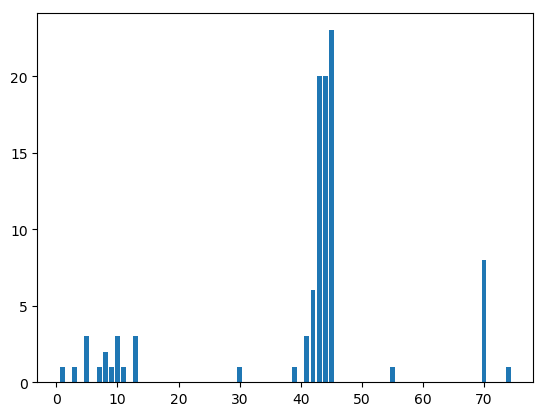

In [30]:
bar(1:74, taubins);

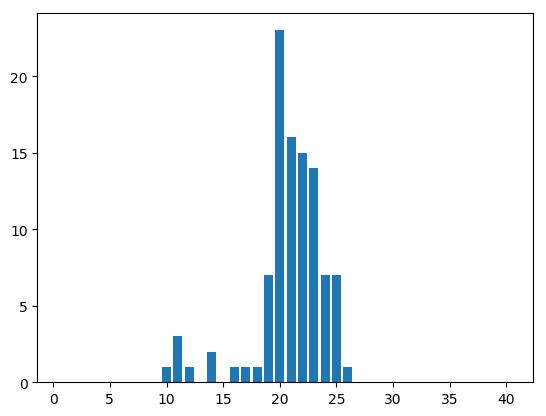

In [31]:
bar(1:40, lambda2bins);

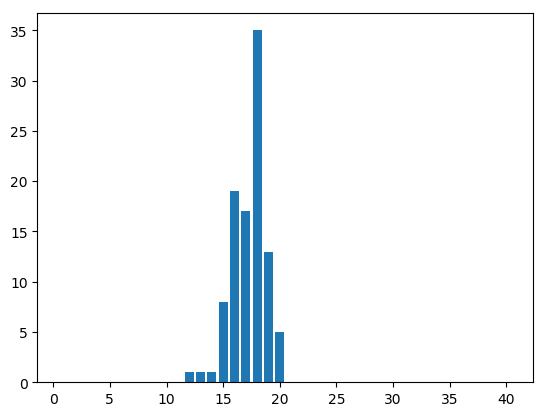

In [32]:
bar(1:40, lambda1bins);